## Titanic Surival rate

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
#from six.moves import urllib

import tensorflow as tf
from keras import layers

tf.__version__


'2.16.2'

In [2]:
dataframe = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv')



In [3]:
dataframe.head()

,survived,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,1,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,1,female,35.0,1,0,53.1000,First,C,Southampton,n
4,0,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [4]:
train, val, test = np.split(dataframe.sample(frac=1), [int(0.8*len(dataframe)), int(0.9*len(dataframe))])

/Users/ayo/anaconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [5]:
CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'deck',
                       'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']



In [6]:
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  df = dataframe.copy()
  labels = df.pop('survived')
  # This line is problematic - should use df, not dataframe
  df = {key: value.to_numpy()[:,tf.newaxis] for key, value in dataframe.items()}
  ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  return ds

In [7]:
batch_size = 5
train_ds = df_to_dataset(train, batch_size=batch_size)

2025-03-31 02:12:55.155605: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-03-31 02:12:55.156122: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-03-31 02:12:55.156172: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-03-31 02:12:55.156976: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-03-31 02:12:55.157015: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [8]:
[(train_features, label_batch)] = train_ds.take(1)
print('Every feature:', list(train_features.keys()))
print('A batch of ages:', train_features['age'])
print('A batch of targets:', label_batch )

Every feature: ['survived', 'sex', 'age', 'n_siblings_spouses', 'parch', 'fare', 'class', 'deck', 'embark_town', 'alone']
A batch of ages: tf.Tensor(
[[28.]
 [38.]
 [28.]
 [ 9.]
 [27.]], shape=(5, 1), dtype=float64)
A batch of targets: tf.Tensor([0 1 1 0 0], shape=(5,), dtype=int64)


2025-03-31 02:12:55.301847: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [9]:
def get_normalization_layer(name, dataset):
  # Create a Normalization layer for the feature.
  normalizer = layers.Normalization(axis=None)

  # Prepare a Dataset that only yields the feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the statistics of the data.
  normalizer.adapt(feature_ds)

  return normalizer

In [10]:
age_count_col = train_features['age']
layer = get_normalization_layer('age', train_ds)
layer(age_count_col)

2025-03-31 02:12:55.750572: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[-0.16893587],
       [ 0.64973754],
       [-0.16893587],
       [-1.7244154 ],
       [-0.2508032 ]], dtype=float32)>

In [11]:
def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
  # Create a layer that turns strings into integer indices.
  if dtype == 'string':
    index = layers.StringLookup(max_tokens=max_tokens)
  # Otherwise, create a layer that turns integer values into integer indices.
  else:
    index = layers.IntegerLookup(max_tokens=max_tokens)

  # Prepare a `tf.data.Dataset` that only yields the feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the set of possible values and assign them a fixed integer index.
  index.adapt(feature_ds)

  # Encode the integer indices.
  encoder = layers.CategoryEncoding(num_tokens=index.vocabulary_size())

  # Apply multi-hot encoding to the indices. The lambda function captures the
  # layer, so you can use them, or include them in the Keras Functional model later.
  return lambda feature: encoder(index(feature))

In [12]:
test_type_col = train_features['sex']
test_type_layer = get_category_encoding_layer(name='sex',
                                              dataset=train_ds,
                                              dtype='string')
test_type_layer(test_type_col)

2025-03-31 02:12:55.840894: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


<tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.]], dtype=float32)>

In [13]:
test_n_siblings_spouses_col = train_features['n_siblings_spouses']
test_n_siblings_spouses_layer = get_category_encoding_layer(name='n_siblings_spouses',
                                             dataset=train_ds,
                                             dtype='int64',
                                             max_tokens=5)
test_n_siblings_spouses_layer(test_n_siblings_spouses_col)

2025-03-31 02:12:55.978351: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


<tf.Tensor: shape=(5, 5), dtype=float32, numpy=
array([[0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.]], dtype=float32)>

In [14]:
batch_size = 256
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

In [15]:
all_inputs = {}
encoded_features = []

In [16]:
for feature_name in NUMERIC_COLUMNS:
  numeric_col = tf.keras.Input(shape=(1,), name=feature_name)
  normalization_layer = get_normalization_layer(feature_name, train_ds)
  encoded_numeric_col = normalization_layer(numeric_col)
  all_inputs[feature_name] = numeric_col
  encoded_features.append(encoded_numeric_col)

2025-03-31 02:12:56.067764: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-03-31 02:12:56.090483: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [17]:
class_col = tf.keras.Input(shape=(1,), name='class', dtype='string')

encoding_layer = get_category_encoding_layer(name='class',
                                             dataset=train_ds,
                                             dtype='string',
                                             max_tokens=5)
encoded_class_col = encoding_layer(class_col)
all_inputs['class'] = class_col
encoded_features.append(encoded_class_col)

2025-03-31 02:12:56.113129: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [18]:
for feature_name in CATEGORICAL_COLUMNS:
  # Determine the dtype based on the feature name
  dtype = 'string' if dataframe[feature_name].dtype == 'object' else 'int64'
  
  categorical_col = tf.keras.Input(shape=(1,), name=feature_name, dtype=dtype)
  encoding_layer = get_category_encoding_layer(name=feature_name,
                                               dataset=train_ds,
                                               dtype=dtype,
                                               max_tokens=5)
  encoded_categorical_col = encoding_layer(categorical_col)
  all_inputs[feature_name] = categorical_col
  encoded_features.append(encoded_categorical_col)

2025-03-31 02:12:56.173694: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-03-31 02:12:56.194888: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-03-31 02:12:56.215565: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-03-31 02:12:56.234667: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-03-31 02:12:56.253659: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-03-31 02:12:56.272899: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [19]:
encoded_features

[<KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=keras_tensor>,
 <KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=keras_tensor_1>,
 <KerasTensor shape=(None, 4), dtype=float32, sparse=False, name=keras_tensor_3>,
 <KerasTensor shape=(None, 3), dtype=float32, sparse=False, name=keras_tensor_5>,
 <KerasTensor shape=(None, 5), dtype=float32, sparse=False, name=keras_tensor_7>,
 <KerasTensor shape=(None, 5), dtype=float32, sparse=False, name=keras_tensor_9>,
 <KerasTensor shape=(None, 5), dtype=float32, sparse=False, name=keras_tensor_11>,
 <KerasTensor shape=(None, 5), dtype=float32, sparse=False, name=keras_tensor_13>,
 <KerasTensor shape=(None, 3), dtype=float32, sparse=False, name=keras_tensor_15>]

In [20]:
all_features = tf.keras.layers.concatenate(encoded_features)

output = tf.keras.layers.Dense(1)(all_features)

model = tf.keras.Model(all_inputs, output)

In [21]:
model.compile(optimizer='adam',
              loss= 'mse',
              metrics=["accuracy"],
              run_eagerly=True)

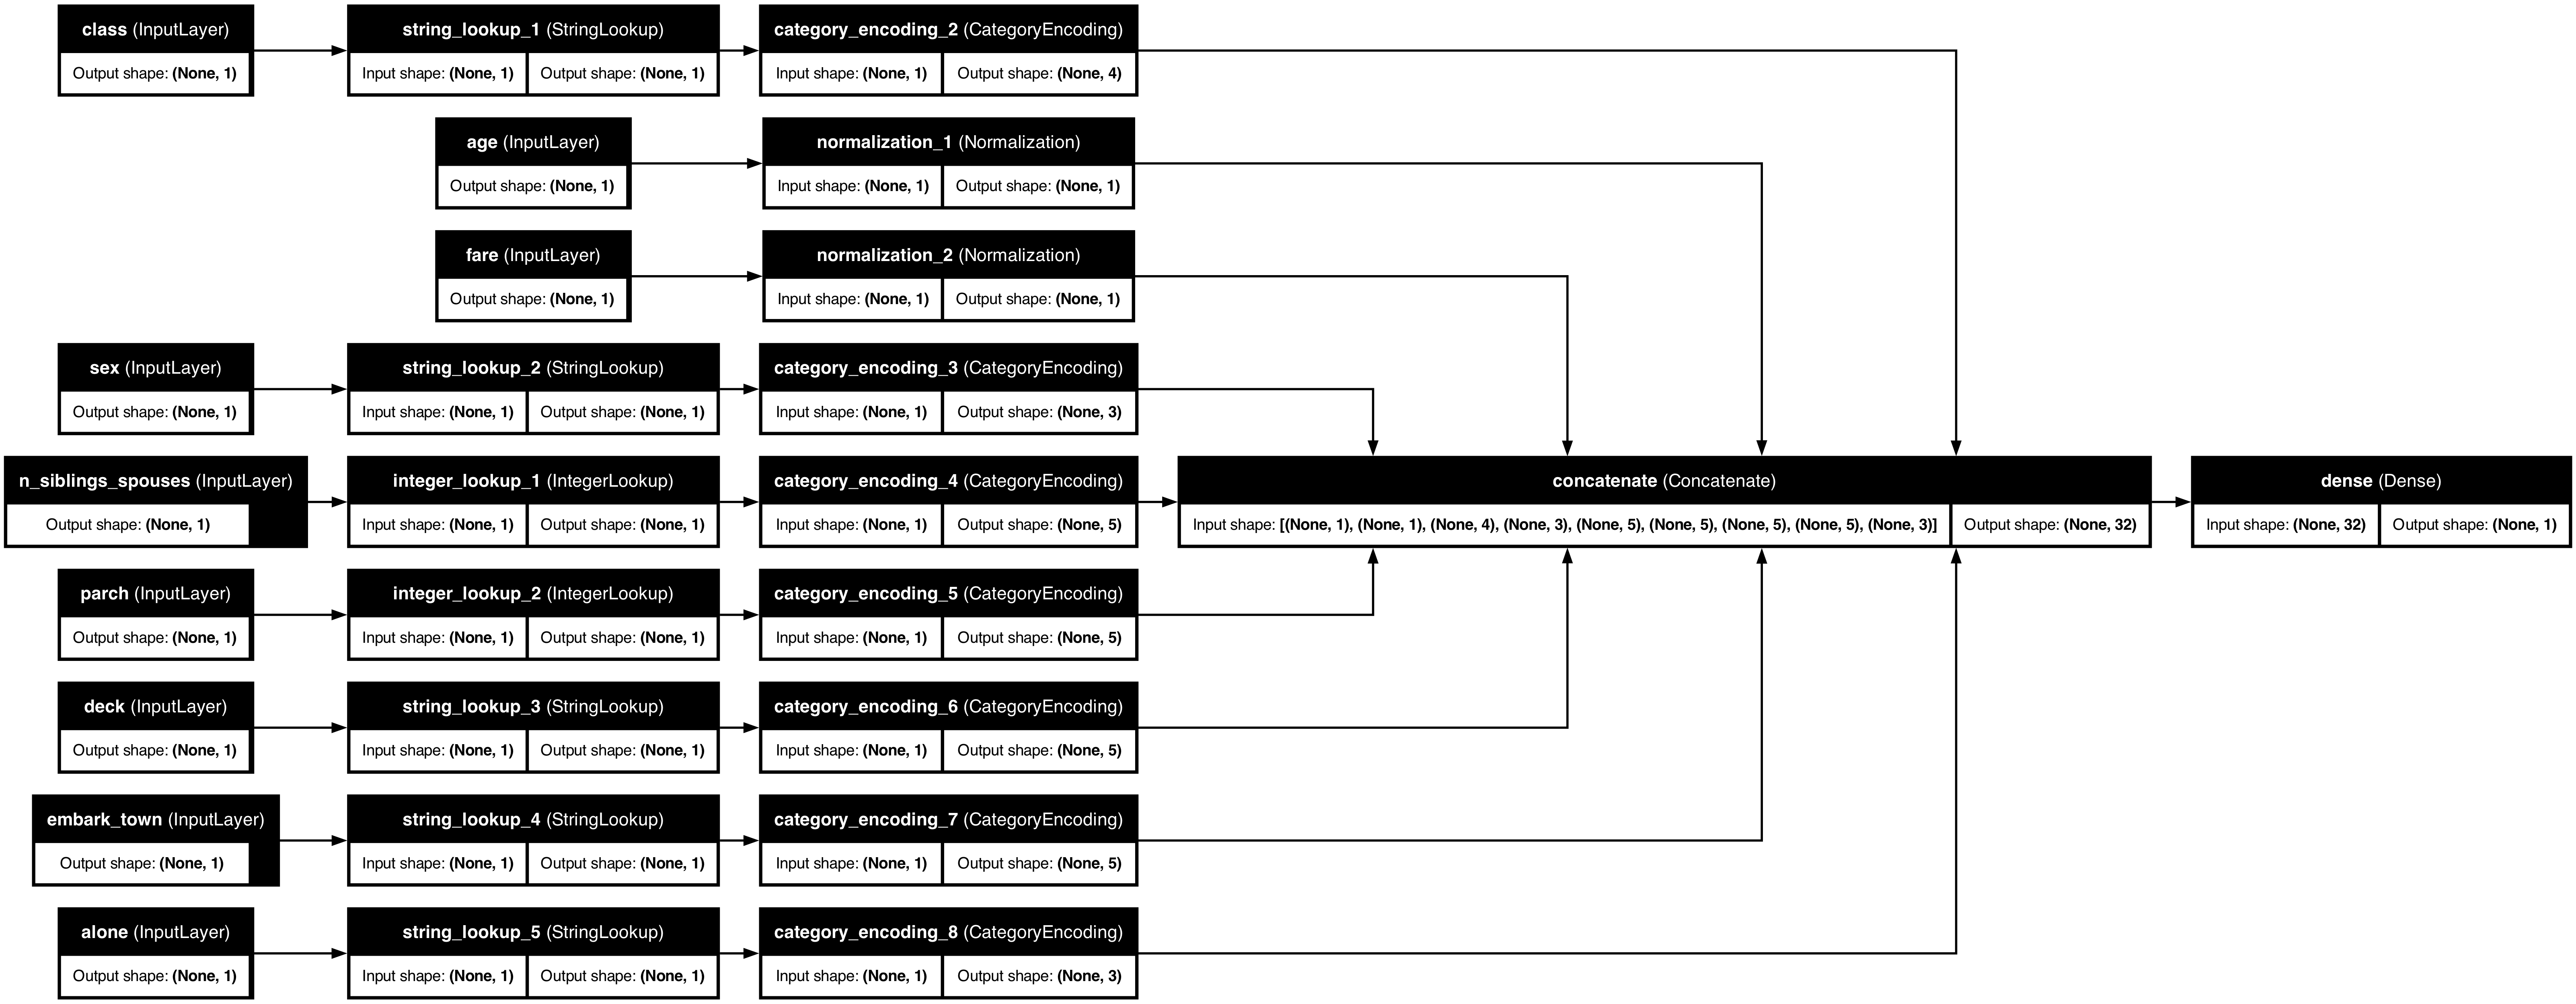

In [22]:
# Use `rankdir='LR'` to make the graph horizontal.
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, rankdir="LR")

In [23]:
model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.6289 - loss: 0.3563

/Users/ayo/anaconda3/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: {'age': 'age', 'fare': 'fare', 'class': 'class', 'sex': 'sex', 'n_siblings_spouses': 'n_siblings_spouses', 'parch': 'parch', 'deck': 'deck', 'embark_town': 'embark_town', 'alone': 'alone'}. Received: the structure of inputs={'survived': '*', 'sex': '*', 'age': '*', 'n_siblings_spouses': '*', 'parch': '*', 'fare': '*', 'class': '*', 'deck': '*', 'embark_town': '*', 'alone': '*'}
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.6261 - loss: 0.3734 - val_accuracy: 0.5397 - val_loss: 0.6005
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.6066 - loss: 0.3863 - val_accuracy: 0.5556 - val_loss: 0.5915
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.6353 - loss: 0.3717 - val_accuracy: 0.5556 - val_loss: 0.5829
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.6314 - loss: 0.3618 - val_accuracy: 0.5556 - val_loss: 0.5749
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.6288 - loss: 0.3574 - val_accuracy: 0.5556 - val_loss: 0.5670
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.6275 - loss: 0.3681 - val_accuracy: 0.5556 - val_loss: 0.5593
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.6249 - loss: 0.3470 - val_accuracy: 0.5556 - val_loss: 0.5517
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.6236 - loss: 0.3535 - val_accuracy: 0.5397 - val_loss: 0.5444
Epoch 9/10

In [24]:
result = model.evaluate(test_ds, return_dict=True)
print(result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6825 - loss: 0.3159
{'accuracy': 0.682539701461792, 'loss': 0.3158661425113678}


In [ ]:
# Get a batch of test data
for test_batch, test_labels in test_ds.take(1):
    # Get predictions for this batch
    predictions = model.predict(test_batch)
    
    # Convert to probabilities
    probabilities = tf.nn.sigmoid(predictions).numpy()
    
    # Convert to binary predictions (0 or 1)
    binary_predictions = (predictions > 0).astype(int)
    
    # Print details for first few passengers
    for i in range(min(5, len(predictions))):
        print("Passenger details:")
        for feature_name, feature_tensor in test_batch.items():
            # Convert tensor value to a readable format
            value = feature_tensor[i].numpy()[0]
            
            # Format string values (decode bytes if necessary)
            if feature_tensor[i].dtype == tf.string:
                value = value.decode('utf-8') if isinstance(value, bytes) else value
                
            print(f"  {feature_name}: {value}")
        
        print(f"Actual survival: {test_labels[i].numpy()}")
        print(f"Predicted survival probability: {probabilities[i][0]:.4f}")
        print(f"Predicted outcome: {'Survived' if binary_predictions[i][0] == 1 else 'Did not survive'}")
        print("-" * 50)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step 
Passenger details:
  survived: 1
  sex: female
  age: 19.0
  n_siblings_spouses: 0
  parch: 0
  fare: 26.0
  class: Second
  deck: unknown
  embark_town: Southampton
  alone: y
Actual survival: 1
Predicted survival probability: 0.4484
Predicted outcome: Did not survive
--------------------------------------------------
Passenger details:
  survived: 1
  sex: female
  age: 16.0
  n_siblings_spouses: 0
  parch: 0
  fare: 7.7333
  class: Third
  deck: unknown
  embark_town: Queenstown
  alone: y
Actual survival: 1
Predicted survival probability: 0.6084
Predicted outcome: Survived
--------------------------------------------------
Passenger details:
  survived: 0
  sex: male
  age: 18.0
  n_siblings_spouses: 0
  parch: 0
  fare: 7.7958
  class: Third
  deck: unknown
  embark_town: Southampton
  alone: y
Actual survival: 0
Predicted survival probability: 0.4911
Predicted outcome: Did not survive
--------------------------------------------------
Passen

/Users/ayo/anaconda3/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: {'age': 'age', 'fare': 'fare', 'class': 'class', 'sex': 'sex', 'n_siblings_spouses': 'n_siblings_spouses', 'parch': 'parch', 'deck': 'deck', 'embark_town': 'embark_town', 'alone': 'alone'}. Received: the structure of inputs={'survived': '*', 'sex': '*', 'age': '*', 'n_siblings_spouses': '*', 'parch': '*', 'fare': '*', 'class': '*', 'deck': '*', 'embark_town': '*', 'alone': '*'}
  warnings.warn(
2025-03-31 02:27:24.997728: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
